In [2]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def ant_box(fname, n):
    """
    Calcuates the normalized width and height of annotations boxes.
    Parameters:
    fname: name of the json file (string)
    n: number of images
    return: numpy array of shape (n, 2), 0th column with width and 1st column with height
    """
    f = open(fname) 
    data = json.load(f) 
    dogs = data['_via_img_metadata']
    ant_size = []
    img_size = []

    #iterating over every annotation and storing the annotation height and width
    for dog in dogs:
        width = dogs[dog]['regions'][0]['shape_attributes']['width']
        height = dogs[dog]['regions'][0]['shape_attributes']['height']
        ant_size.append([width, height])

    #iterating over images and storing their shape
    for i in range(1,n+1):
        img = cv2.imread('dog_{}.jpeg'.format(i))
        shape = img.shape #0:height, 1:width
        img_size.append(list(shape[0:2]))

    #converting to numpy array
    ant_size = np.array(ant_size)
    img_size = np.array(img_size)

    #swapping img_size columns so that 0:width, 1:height
    img_size[:,[0,1]]=img_size[:,[1,0]]

    #normalizing annotation w and h with image w and h
    wh = np.divide(ant_size, img_size)

    #rounding off to 3 decimal places
    wh = np.around(wh, 3)

    #closing the json file
    f.close()

    return wh

In [4]:
def plot_wh(wh):
    plt.scatter(wh[:,0],wh[:,1],alpha=0.7)
    plt.title("Clusters")
    plt.xlabel("Normalized width")
    plt.ylabel("Normalized height")
    plt.show()

In [5]:
def iou(box, clusters):
    """
    Calculates intersection over unions and returns the value.
    Parameters:
    box:      np.array of shape (2,) containing w and h
    clusters: np.array of shape (N cluster, 2)
    return: iou value
    """
    x = np.minimum(clusters[:, 0], box[0]) 
    y = np.minimum(clusters[:, 1], box[1])

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou_ = intersection / (box_area + cluster_area - intersection)

    return iou_

In [6]:
def kmeans(boxes, k, dist=np.median, seed=1):
    """
    Calculates k clusters (using k-means clustering) with the Intersection over Union (IoU) metric.
    Parameters:
    boxes: numpy array of shape (r, 2), where r is the number of rows
    k: number of clusters
    dist: distance function
    return: numpy array of shape (k, 2)
    """
    rows = boxes.shape[0]

    distances     = np.empty((rows, k)) ## N row x N cluster
    last_clusters = np.zeros((rows,))

    np.random.seed(seed)

    # initialize the cluster centers to be k items
    clusters = boxes[np.random.choice(rows, k, replace=False)]

    while True:
        # Step 1: allocate each item to the closest cluster centers
        for icluster in range(k):
            distances[:,icluster] = 1 - iou(clusters[icluster], boxes)

        nearest_clusters = np.argmin(distances, axis=1)

        if (last_clusters == nearest_clusters).all():
            break
            
        # Step 2: calculate the cluster centers as mean (or median) of all the cases in the clusters.
        for cluster in range(k):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

    return clusters,nearest_clusters,distances

In [7]:
def plot_cluster_result(plt,clusters,nearest_clusters,WithinClusterSumDist,wh):
    for icluster in np.unique(nearest_clusters):
        pick = nearest_clusters==icluster
        c = current_palette[icluster]
        plt.rc('font', size=8) 
        plt.plot(wh[pick,0],wh[pick,1],"p",
                 color=c,
                 alpha=0.5,label="cluster = {}, N = {:6.0f}".format(icluster,np.sum(pick)))
        plt.text(clusters[icluster,0],
                 clusters[icluster,1],
                 "c{}".format(icluster),
                 fontsize=20,color="red")
        plt.title("Clusters")
        plt.xlabel("width")
        plt.ylabel("height")
    plt.legend(title="Mean IoU = {:5.4f}".format(WithinClusterSumDist))  

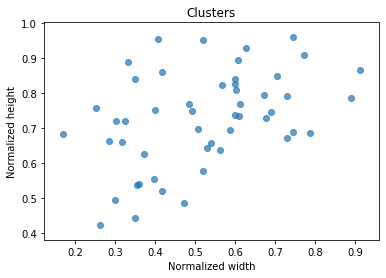

In [8]:
wh = ant_box('dog_images.json', 50)
plot_wh(wh)

In [9]:
kmax = 11
dist = np.mean
results = {}
for k in range(2,kmax):
    clusters, nearest_clusters, distances = kmeans(wh,k,seed=2,dist=dist)
    WithinClusterMeanDist = np.mean(distances[np.arange(distances.shape[0]),nearest_clusters])
    result = {"clusters":             clusters,
              "nearest_clusters":     nearest_clusters,
              "distances":            distances,
              "WithinClusterMeanDist": WithinClusterMeanDist}
    print("{:2.0f} clusters: mean IoU = {:5.4f}".format(k,1-result["WithinClusterMeanDist"]))
    results[k] = result

 2 clusters: mean IoU = 0.7627
 3 clusters: mean IoU = 0.7942
 4 clusters: mean IoU = 0.8150
 5 clusters: mean IoU = 0.8300
 6 clusters: mean IoU = 0.8496
 7 clusters: mean IoU = 0.8586
 8 clusters: mean IoU = 0.8646
 9 clusters: mean IoU = 0.8709
10 clusters: mean IoU = 0.8724


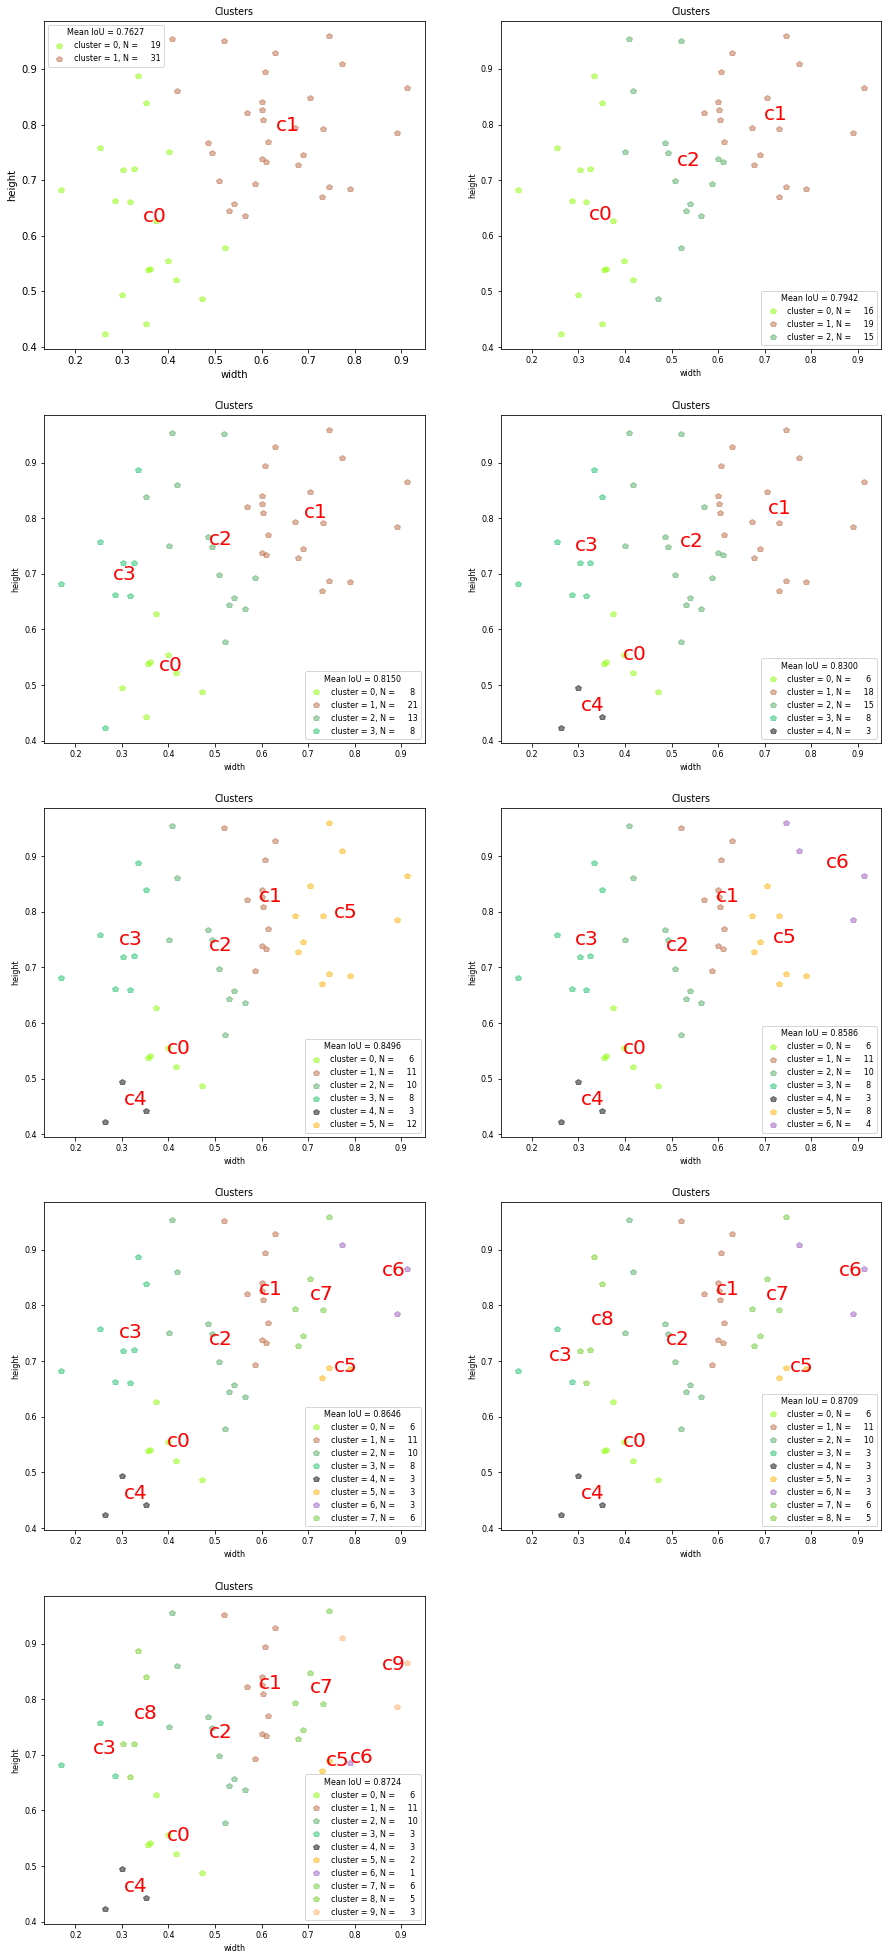

In [10]:
current_palette = list(sns.xkcd_rgb.values())

figsize = (15,35)
count =1 
fig = plt.figure(figsize=figsize)
for k in range(2,kmax):
    result               = results[k]
    clusters             = result["clusters"]
    nearest_clusters     = result["nearest_clusters"]
    WithinClusterSumDist = result["WithinClusterMeanDist"]
    
    ax = fig.add_subplot(kmax/2,2,count)
    plot_cluster_result(plt,clusters,nearest_clusters,1 - WithinClusterSumDist,wh)
    count += 1
plt.show()

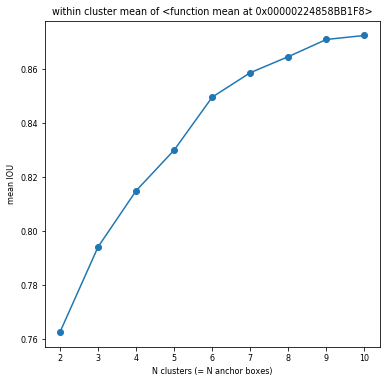

In [11]:
plt.figure(figsize=(6,6))
plt.plot(np.arange(2,kmax),
         [1 - results[k]["WithinClusterMeanDist"] for k in range(2,kmax)],"o-")
plt.title("within cluster mean of {}".format(dist))
plt.ylabel("mean IOU")
plt.xlabel("N clusters (= N anchor boxes)")
plt.show()

In [13]:
Nanchor_box = 6
results[Nanchor_box]["clusters"]

array([[0.39616667, 0.54483333],
       [0.59454545, 0.81836364],
       [0.487     , 0.7293    ],
       [0.2925    , 0.740875  ],
       [0.30466667, 0.453     ],
       [0.75516667, 0.78883333]])

In [14]:
Nanchor_box = 5
results[Nanchor_box]["clusters"]

array([[0.39616667, 0.54483333],
       [0.70644444, 0.80733333],
       [0.51706667, 0.7486    ],
       [0.2925    , 0.740875  ],
       [0.30466667, 0.453     ]])

In [15]:
Nanchor_box = 4
results[Nanchor_box]["clusters"]

array([[0.3785    , 0.525625  ],
       [0.6902381 , 0.80114286],
       [0.48676923, 0.752     ],
       [0.2815    , 0.688875  ]])